In [1]:
import SimpleITK as sitk
import os
import shutil
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import pydicom
import cv2
import matplotlib.pyplot as plt
import scipy.interpolate as spi
import re

In [2]:
# for relative paths
import sys
base_path = os.getcwd()
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/training"))

In [3]:
# View DICOM image 
def view_dicom_image(dicom_file):
    """
    View a DICOM image.
    """
    # Load the DICOM file
    image = sitk.ReadImage(dicom_file)
    image_np = sitk.GetArrayFromImage(image)
    # Plot the image
    plt.imshow(image_np[0], cmap='gray')
    plt.show()

def view_nii_image(nii_file):
    """
    View a NIfTI image.
    """
    image = sitk.ReadImage(nii_file)
    image_np = sitk.GetArrayFromImage(image)
    plt.imshow(image_np[..., 0], cmap="gray")
    plt.show()

def view_image(image_np_path):
    """
    View a 2D image.
    """
    image_np = np.load(image_np_path)
    plt.imshow(image_np, cmap="gray")
    plt.show()

def view_nii_mask(nii_file):
    """
    View a NIfTI mask.
    """
    image = sitk.ReadImage(nii_file)
    image_np = sitk.GetArrayFromImage(image)
    if image_np.ndim == 2:
        plt.imshow(image_np, cmap="gray")
    elif image_np.ndim == 3:
        plt.imshow(image_np[0], cmap="gray")
    else:
        raise ValueError(f"Unsupported image shape: {image_np.shape}")
    plt.show()

In [4]:
# Load the NIfTI file
filename = os.path.join(dataset_path, 'patient002\patient002_4d.nii.gz')
output_dir = "slices_output"  # Directory to save slices
os.makedirs(output_dir, exist_ok=True)

# Load the NIfTI file
img = nib.load(filename)
data = img.get_fdata()  # Shape: (X, Y, Z, T)

# Extract slices for each time frame
time_frames = data.shape[-1]  # T dimension
for t in range(time_frames):
    # Data for the current time frame
    time_frame_data = data[..., t]  # Shape: (X, Y, Z)
    print(f"Time frame {t}: {time_frame_data.shape}")
    
    # Save slices along a chosen axis (e.g., axial - Z axis)
    for z in range(time_frame_data.shape[2]):  # Z slices
        slice_data = time_frame_data[:, :, z]
        
        # Save the slice as a .npy file (can replace this with image saving)
        slice_filename = os.path.join(output_dir, f"time{t:03d}_slice{z:03d}.npy")
        np.save(slice_filename, slice_data)
        
        # (Optional) Convert and save as image (requires matplotlib or PIL)
        # from matplotlib import pyplot as plt
        # plt.imsave(slice_filename.replace('.npy', '.png'), slice_data, cmap='gray')

print(f"Slices saved to {output_dir}")

Time frame 0: (232, 256, 10)
Time frame 1: (232, 256, 10)
Time frame 2: (232, 256, 10)
Time frame 3: (232, 256, 10)
Time frame 4: (232, 256, 10)
Time frame 5: (232, 256, 10)
Time frame 6: (232, 256, 10)
Time frame 7: (232, 256, 10)
Time frame 8: (232, 256, 10)
Time frame 9: (232, 256, 10)
Time frame 10: (232, 256, 10)
Time frame 11: (232, 256, 10)
Time frame 12: (232, 256, 10)
Time frame 13: (232, 256, 10)
Time frame 14: (232, 256, 10)
Time frame 15: (232, 256, 10)
Time frame 16: (232, 256, 10)
Time frame 17: (232, 256, 10)
Time frame 18: (232, 256, 10)
Time frame 19: (232, 256, 10)
Time frame 20: (232, 256, 10)
Time frame 21: (232, 256, 10)
Time frame 22: (232, 256, 10)
Time frame 23: (232, 256, 10)
Time frame 24: (232, 256, 10)
Time frame 25: (232, 256, 10)
Time frame 26: (232, 256, 10)
Time frame 27: (232, 256, 10)
Time frame 28: (232, 256, 10)
Time frame 29: (232, 256, 10)
Slices saved to slices_output


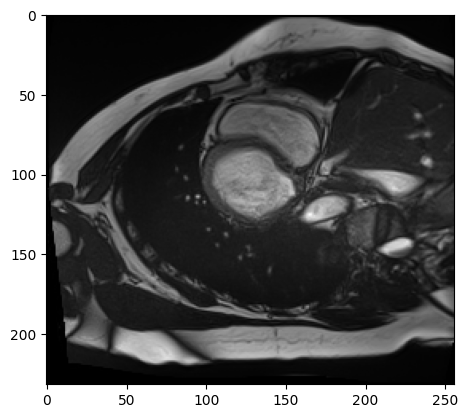

In [5]:
# view slices
view_image("slices_output/time000_slice000.npy")

In [6]:
img = nib.load(os.path.join(dataset_path, 'patient002\patient002_frame01.nii.gz'))
data = img.get_fdata()  # Shape: (X, Y, Z)
print(data.shape)

(232, 256, 10)



# Standardize Spacing and Dimensions


In [7]:
# Standardize the spacing

def clone_directory_structure(src, dst):
    """
    Clone the directory structure from src to dst.
    """
    for root, dirs, files in os.walk(src):
        # Create the corresponding directory in the destination
        dst_dir = root.replace(src, dst, 1)  # Replace src with dst in the path
        os.makedirs(dst_dir, exist_ok=True)  # Create the directory if it doesn't exist

def monotonic_zoom_interpolate(image_np, resize_factor):
    """
    Apply monotonic zoom interpolation to a given image.
    """
    result = image_np.copy()
    
    for axis, factor in enumerate(resize_factor[::-1]):
        # Create a new array for the interpolated values
        new_length = int(result.shape[axis] * factor)
        x_old = np.arange(result.shape[axis])
        x_new = np.linspace(0, result.shape[axis] - 1, new_length)
        
        # Perform monotonic interpolation
        pchip_interp = spi.PchipInterpolator(x_old, result.take(indices=x_old, axis=axis), axis=axis)
        result = pchip_interp(x_new)

    return result

def process_single_slice_dicom(image, target_resolution):
    """
    Load and standardize the spacing of a single-slice DICOM file.
    """
    
    # Load the DICOM file
    current_spacing = np.array(image.GetSpacing())

    resize_factor = np.array([current_spacing[0] / target_resolution[0], 
                               current_spacing[1] / target_resolution[1], 
                               1.0])

    new_real_shape = np.array(image.GetSize()) * resize_factor

    new_shape = np.round(new_real_shape).astype(int)
    
    real_resize_factor = new_shape / np.array(image.GetSize())
    
    image_np = sitk.GetArrayFromImage(image)

    # image_resampled_np = zoom(image_np, real_resize_factor[::-1], order=1)
    image_resampled_np = monotonic_zoom_interpolate(image_np, real_resize_factor)

    image_resampled = sitk.GetImageFromArray(image_resampled_np)

    new_spacing = np.array([target_resolution[0], target_resolution[1], current_spacing[2]])

    image_resampled.SetSpacing(new_spacing)
    
    print(f"Original shape: {image_np.shape}, Resampled shape: {image_resampled_np.shape}")
    print(f"Resampled shape: {image_resampled.GetSize()}")
    print(f"Original spacing: {current_spacing}, New spacing: {image_resampled.GetSpacing()}")

    return image_resampled


def loop_and_standardize(dataset_path, target_resolution, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    clone_directory_structure(dataset_path, output_path)
    max_patients = 300
    patient_count = 0 

    for root, dirs, files in os.walk(dataset_path):
        print(f"Processing directory: {root}")
        for file in files:
            if search_term in file and file.endswith(".nii.gz") and patient_count < max_patients: 
                nifti_file_path = os.path.join(root, file)
                print(f"Processing: {nifti_file_path}")
                patient_count += 1
                # Load the NIfTI file
                img = nib.load(nifti_file_path)
                data = img.get_fdata()  # Shape: (X, Y, Z, T)
                # print(f"Shape of data: {data.shape}")

                # Extract and process slices for each time frame
                time_frames = data.shape[-1]  # T dimension
                for t in range(time_frames):
                    # Data for the current time frame
                    time_frame_data = data[..., t]  # Shape: (X, Y, Z)
                    print(f"Time frame {t}: {time_frame_data.shape}")
                    # Transpose from (216, 256, 10) -> (10, 256, 216)
                    time_frame_data = np.transpose(time_frame_data, (2, 1, 0))   
                       
                    slice_image = sitk.GetImageFromArray(time_frame_data)
                    print("Corrected shape of slice_image: ", slice_image.GetSize())
    
                    # Process and save in the corresponding output directory
                    processed_image = process_single_slice_dicom(slice_image, target_resolution)

                    
                    print("Processed shape of slice_image: ", processed_image.GetSize())
                    output_dir = root.replace(dataset_path, output_path, 1)
                    os.makedirs(output_dir, exist_ok=True)
                    output_file = os.path.join(output_dir, f"time{t:03d}.nii.gz")

                    sitk.WriteImage(processed_image, output_file)
                    print(f"Saved standardized slice: {output_file}")


# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/training"))
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data

testing_dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/testing"))
testing_output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/test_standardized"))  # New path for standardized data

target_spacing = np.array([1.0, 1.0, 1.0])  # Example target resolution (x, y, z spacing)

loop_and_standardize(testing_dataset_path, target_spacing, testing_output_path)


Processing directory: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\testing
Processing directory: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\testing\patient101
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\testing\patient101\patient101_4d.nii.gz
Time frame 0: (232, 256, 10)
Corrected shape of slice_image:  (232, 256, 10)
Original shape: (10, 256, 232), Resampled shape: (10, 256, 232)
Resampled shape: (232, 256, 10)
Original spacing: [1. 1. 1.], New spacing: (1.0, 1.0, 1.0)
Processed shape of slice_image:  (232, 256, 10)
Saved standardized slice: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time000.nii.gz
Time frame 1: (232, 256, 10)
Corrected shape of slice_image:  (232, 256, 10)
Original shape: (10, 256, 232), Resampled shape: (10, 256, 232)
Resampled shape: (232, 256, 10)
Original spacing: [1. 1. 1.], New spacing: (1.0, 1.0, 1.0)
Processed shape of slice_image:  (232, 256, 10)

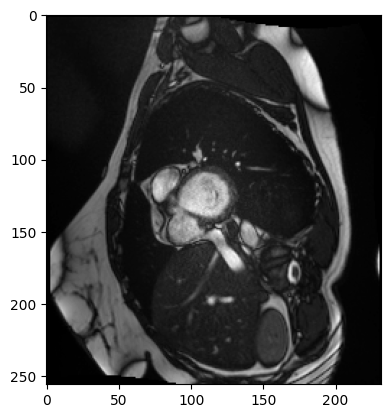

Shape of standardized image: (232, 256, 10)


In [8]:
# # View the standardized image
# view_dicom_image("../../../Data/ACDC/database/train_standardized/patient001/time001.nii.gz")
# print(f"Shape of standardized image: {sitk.ReadImage('../../../Data/ACDC/database/train_standardized/patient001/time001.nii.gz').GetSize()}")

# View the testing standardized image
view_dicom_image("../../../Data/ACDC/database/test_standardized/patient101/time001.nii.gz")
print(f"Shape of standardized image: {sitk.ReadImage('../../../Data/ACDC/database/test_standardized/patient101/time001.nii.gz').GetSize()}")

In [9]:

def check_unified_resolution(output_path):
    """
    Check if all images in the output directory have unified resolution and print the frame numbers for each resolution.
    """
    resolutions = {}  # To store resolutions and corresponding frame numbers

    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    spacing = tuple(image.GetSpacing())  # Get the spacing (resolution) and convert to tuple
                    if spacing not in resolutions:
                        resolutions[spacing] = []
                    resolutions[spacing].append(file)  # Add the file name to the corresponding resolution

                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

    # Print the resolutions and corresponding frame numbers
    for res, files in resolutions.items():
        print(f"Resolution: {res}")
        for file in files:
            print(f"  Frame: {file}")

# Example usage:
check_unified_resolution(output_path)


Resolution: (1.0, 1.0, 1.0)
  Frame: time000.nii.gz
  Frame: time001.nii.gz
  Frame: time002.nii.gz
  Frame: time003.nii.gz
  Frame: time004.nii.gz
  Frame: time005.nii.gz
  Frame: time006.nii.gz
  Frame: time007.nii.gz
  Frame: time008.nii.gz
  Frame: time009.nii.gz
  Frame: time010.nii.gz
  Frame: time011.nii.gz
  Frame: time012.nii.gz
  Frame: time013.nii.gz
  Frame: time014.nii.gz
  Frame: time015.nii.gz
  Frame: time016.nii.gz
  Frame: time017.nii.gz
  Frame: time018.nii.gz
  Frame: time019.nii.gz
  Frame: time020.nii.gz
  Frame: time021.nii.gz
  Frame: time022.nii.gz
  Frame: time023.nii.gz
  Frame: time024.nii.gz
  Frame: time025.nii.gz
  Frame: time026.nii.gz
  Frame: time027.nii.gz
  Frame: time028.nii.gz
  Frame: time029.nii.gz
  Frame: time000.nii.gz
  Frame: time001.nii.gz
  Frame: time002.nii.gz
  Frame: time003.nii.gz
  Frame: time004.nii.gz
  Frame: time005.nii.gz
  Frame: time006.nii.gz
  Frame: time007.nii.gz
  Frame: time008.nii.gz
  Frame: time009.nii.gz
  Frame: tim

# Normalize

In [10]:
def normalize_file_by_file(dicom_file, output_dir):
    """
    load and normalize single slice dicome file by z-score normalization
    """
    image = sitk.ReadImage(dicom_file)
    image_np = sitk.GetArrayFromImage(image)
    mean = image_np.mean()
    std = image_np.std()
    image_np = (image_np - mean) / std
    image = sitk.GetImageFromArray(image_np)
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(image, output_file)
    print(f"Saved: {output_dir}")
    print(f"Mean: {mean}, Std: {std}")
    

def loop_and_normalize(dataset_path, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    # clone_directory_structure(dataset_path, output_path)

    for root, dirs, files in os.walk(dataset_path):
        # Ignore directories with '4d' in their name
                for file in files:
                            if file.endswith(".nii.gz"):  # Assuming DICOM files are used
                                dicom_file_path = os.path.join(root, file)
                                print(f"Processing: {dicom_file_path}")
                                
                                # Process and save in the corresponding output directory
                                output_dir = root.replace(dataset_path, output_path, 1)
                                normalize_file_by_file(dicom_file_path, output_dir)
# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data
# loop_and_normalize(dataset_path, output_path)
loop_and_normalize(testing_output_path, testing_output_path)

Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time000.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101
Mean: 51.964584455818965, Std: 37.10325162885692
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time001.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101
Mean: 52.10327990301724, Std: 37.0075966764094
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time002.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101
Mean: 52.05030475484914, Std: 37.000361864348555
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time003.nii.gz
Saved: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\pa

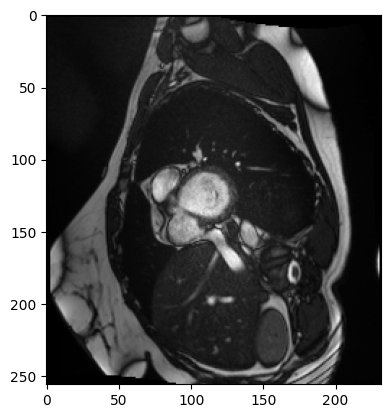

In [11]:
# View the normalized image
# view_dicom_image("../../../Data/ACDC/database/train_standardized/patient001/time001.nii.gz")
view_dicom_image("../../../Data/ACDC/database/test_standardized/patient101/time001.nii.gz")

In [12]:
def check_image_values(output_path):
    """
    Check the minimum and maximum pixel values of the images in the output directory.
    """
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    image_np = sitk.GetArrayFromImage(image)
                    print(f"Min: {image_np.min()}, Max: {image_np.max()} for: {nifti_file_path}")
                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Path where standardized images are saved
# check_image_values(output_path)
check_image_values(testing_output_path)

Min: -1.0232144836139418, Max: 5.472173101569108 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time000.nii.gz
Min: -1.029606981404072, Max: 5.482569480830942 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time001.nii.gz
Min: -1.028376557352328, Max: 5.485073253856515 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time002.nii.gz
Min: -1.0273973216928485, Max: 5.48080727012373 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time003.nii.gz
Min: -1.0262372255591383, Max: 5.473150443131342 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time004.nii.gz
Min: -1.0255648315141976, Max: 5.467284224988167 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time005.nii.gz
Min: -1.0241471659665013, Max: 5.4433389234

In [13]:
# standardize the Dimension by padding
def process_Dimension_by_padding(dicom_file, target_resolution, output_dir):
    """
    Load and standardize the resolution of a single-slice DICOM file using padding.
    """
    image = sitk.ReadImage(dicom_file)
    constant_val = int(sitk.GetArrayFromImage(image).min())

    current_size = np.array(image.GetSize())
    padding_left_right = target_resolution[0] - current_size[0]
    padding_top_bottom = target_resolution[1] - current_size[1]
    padding_left = int(padding_left_right // 2)
    padding_right = int(padding_left_right - padding_left)
    padding_top = int(padding_top_bottom // 2)
    padding_bottom = int(padding_top_bottom - padding_top)

    transformed = sitk.ConstantPad(image,(padding_left,padding_top,0),(padding_right,padding_bottom,0),constant_val)
    
    
    
    output_file = os.path.join(output_dir, os.path.basename(dicom_file))
    sitk.WriteImage(transformed, output_file)

def loop_and_standardize(dataset_path, target_resolution, output_path, search_term="4d"):
    """
    Loop over the dataset, clone the folder structure, and standardize the resolution of single-slice data.
    """
    # Clone the directory structure
    # clone_directory_structure(dataset_path, output_path)

    for root, dirs, files in os.walk(dataset_path):
        # Ignore directories with '4d' in their name
            for file in files:
                    if file.endswith(".nii.gz"):  # Assuming DICOM files are used
                        dicom_file_path = os.path.join(root, file)
                        print(f"Processing: {dicom_file_path}")
                        
                        # Process and save in the corresponding output directory
                        output_dir = root.replace(dataset_path, output_path, 1)
                        process_Dimension_by_padding(dicom_file_path, target_resolution, output_dir)

# Example usage:
dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # New path for standardized data
target_spacing = np.array([512, 512,1.0])  # Example target resolution (x, y, z spacing)

# loop_and_standardize(dataset_path, target_spacing, output_path)
loop_and_standardize(testing_output_path, target_spacing, testing_output_path)  # Testing dataset

Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time000.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time001.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time002.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time003.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time004.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time005.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time006.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time007.nii.gz
Processing: d:\study\graduation project\GP-2025-Strain\D

In [14]:
# check if their is a resolution more than 512x512
def check_Dimension(output_path):
    """
    Check if all images in the output directory have a resolution of 512x512.
    """
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    size = image.GetSize()  # Get the size (resolution)
                    if size[0] == 512 or size[1] == 512:
                        print(f"Resolution is 512x512 for: {nifti_file_path}")
                    else:
                        print(f"Resolution lower 512x512 for: {nifti_file_path}")
                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Path where standardized images are saved
# check_Dimension(output_path)
check_Dimension(testing_output_path)

Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time000.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time001.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time002.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time003.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time004.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time005.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain\Data\ACDC\database\test_standardized\patient101\time006.nii.gz
Resolution is 512x512 for: d:\study\graduation project\GP-2025-Strain

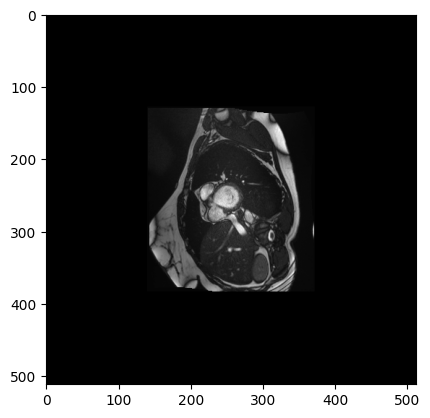

In [15]:
# View final image
# view_dicom_image("../../../Data/ACDC/database/train_standardized/patient001/time001.nii.gz")
view_dicom_image("../../../Data/ACDC/database/test_standardized/patient101/time001.nii.gz")

In [16]:

def create_numpy_array(patient_root, output_path):
    # save each slice of the time frame as a numpy array
    patient_id = os.path.basename(patient_root)
    patient_output_path = os.path.join(output_path, patient_id)
    os.makedirs(patient_output_path, exist_ok=True)
    
    for root, dirs, files in os.walk(patient_root):
        for file in files:
            if file.endswith(".nii.gz"):  # Check for NIfTI files
                nifti_file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(nifti_file_path)
                    image_np = sitk.GetArrayFromImage(image)
                    # Extract frame number from file name
                    frame_number = extract_frame_number(file)
                    # save it in this naming convention _frame{frame_number}_slice_{slice}_ACDC.npy
                    for i in range(image_np.shape[0]):
                        file_name = f"{patient_id}_frame{frame_number}_slice_{i+1}_ACDC.npy"
                        np.save(os.path.join(patient_output_path, file_name), image_np[i])
                except Exception as e:
                    print(f"Failed to read {nifti_file_path}: {str(e)}")

    
def extract_frame_number(file_name):
    # Extract digits after 'time' using regex
    match = re.search(r'time(\d+)', file_name)
    if match:
        frame_number = int(match.group(1))  # Extract the number
        return f"{frame_number:02d}"  # Format to 2 digits
    else:
        return None
    

def loop_over_data_set_and_create_numpy(dataset_path, output_path, search_term="4d"):
    """
    Loop over the dataset, add in seperate folder, and standardize the resolution of single-slice data.
    """
    

    for folder in os.listdir(dataset_path):
        create_numpy_array(os.path.join(dataset_path, folder), output_path)

    
        

dataset_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_standardized"))  # Original dataset path
output_path = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_numpy" )) # New path for standardized data
# loop_over_data_set_and_create_numpy(dataset_path, output_path)
loop_over_data_set_and_create_numpy(testing_output_path, output_path)


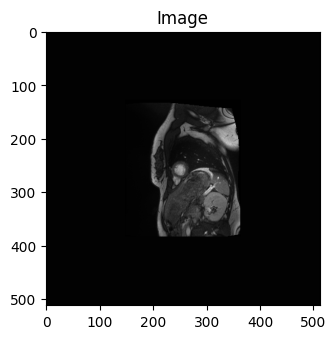

In [20]:
#plot the numpy array  image
def plot_numpy_array(numpy_file):
    """
    Plot a 2-channel NumPy array.
    """
    # Load the NumPy array
    numpy_array = np.load(numpy_file)
    
    image = numpy_array

    plt.figure(figsize=(12, 4))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap='gray')
    plt.show()

# Example usage:
numpy_file = os.path.abspath(os.path.join(base_path, "../../../Data/ACDC/database/train_numpy/patient150/patient150_frame29_slice_7_ACDC.npy"))
plot_numpy_array(numpy_file)